# Kaggle Project

## Describe Your Dataset

#### URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset?resource=download

#### Task: binary classification
##### why do you do this?
- This data set is a collection of 2,000 Bike and Car images. While collecting these images, It was made sure that all types of bikes and cars are included in the image collection. This is because of the high Intra-variety of cars and bikes. That is, there are different types of cars and bikes, which make it a little tough task for the model because the model will also have to understand the high variety of bikes and cars. But if your model is able to understand the basic structure of a car and a bike, it will be able to distinguish between both classes.<br/>

##### what are you working on?
- We are trying to solve the **binary classification problem** of cars and bikes.

#### Datasets
- There are a total of 4000 images including car and bike images. The learning proceeds by dividing it into 6:2:2 in order of train, validation, and test. From a total of 4000 images, the train dataset consists of 2400, validation dataset 800, and test dataset 800, respectively. When dividing images into train validation tests, they are randomly selected and divided.<br/>


- Train dataset: **2400** images of cars and bikes
- Validation dataset: **800** images of cars and bikes
- Test dataset: **800** images of cars and bikes

#### Features(x):
- All car and bike images are in unprocessed state. So the images are of different sizes. For model learning, each image is resized and changed to a size of 224,224 before learning.<br/>


- feature (x) size: **(224(height),224(width))** in mid-term project, **(256(height),256(width))** in final-project
- feature (x) data type: torch.tensor
- batch size: **512** in mid-term project and **32** and **16** in final-project
- model input size: **(batch,3(channel),height,width)**
- model output size: **(batch,2(num classes)**

#### Target(y):
- This problem is binary classification. So, label the car as 0 and the bike as 1, and proceed with learning.
- bike: 0 
- car: 1
- target y data type: torch.tensor
- batch size: **512** in mid-term project and **32** and **16** in final-project
- label size: **(batch,1(label))**
---

In [1]:
import pandas as pd
annotation_df = pd.read_csv("./annotation_file/all.csv")
train_df = pd.read_csv("./annotation_file/train.csv")
validation_df = pd.read_csv("./annotation_file/validation.csv")
test_df = pd.read_csv("./annotation_file/test.csv")

print("="*45)
print('\033[92m' + '\033[1m' + "4000개의 Car & Bike annotation all" + '\033[0m')
print(annotation_df.shape)
print(annotation_df["vehicle_type"].value_counts().sort_index())
print("="*45)
################################################################################################
# train & validation & test annotation split
################################################################################################
print('\033[92m' + '\033[1m' + "2400개의 Car & Bike annotation train" + '\033[0m')
print(train_df.shape)
print(train_df["vehicle_type"].value_counts().sort_index())
print("="*45)
################################################################################################
print('\033[92m' + '\033[1m' + "800개의 Car & Bike annotation validation" + '\033[0m')
print(validation_df.shape)
print(validation_df["vehicle_type"].value_counts().sort_index())
print("="*45)
################################################################################################
print('\033[92m' + '\033[1m' + "800개의 Car & Bike annotation test" + '\033[0m')
print(test_df.shape)
print(test_df["vehicle_type"].value_counts().sort_index())
print("="*45)
################################################################################################

4000개의 Car & Bike annotation all
(4000, 3)
Bike    2000
Car     2000
Name: vehicle_type, dtype: int64
2400개의 Car & Bike annotation train
(2400, 3)
Bike    1187
Car     1213
Name: vehicle_type, dtype: int64
800개의 Car & Bike annotation validation
(800, 3)
Bike    408
Car     392
Name: vehicle_type, dtype: int64
800개의 Car & Bike annotation test
(800, 3)
Bike    405
Car     395
Name: vehicle_type, dtype: int64


# 필요한 package import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from torch.utils.data import DataLoader

import torchsummary

from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

### Define Dataset class
- 위에서 설명했던 바와 같이 dataset class를 정의.

### annotation type
- train, validation, test 중에서 하나를 선택하여 dataset class object를 생성할 수 있음.
- 3가지 option 중 하나를 선택하여 dataset class object를 생성하면 option에 맞는 annotation file을 선택.

### data augmentation - torchvision.transforms.AutoAugment()
- torchvision.transforms package에는 ImageNet에서 자주 사용된 data augmentation을 자동으로 적용하여 x(input) 데이터를 생성해주는 package가 있음.
- data가 많지 않는 상황에서 model의 일반화 성능을 올리기 위해서는 필요한 작업이라고 생각이 들어 augmenation 진행.
- train 할 때는 data augmentation을 진행하지만 validation, test 할 때는 data augmentation을 진행하지 않음.

### torchvision.transforms.Resize() & Normalize()
- train, validation, test를 진행할 때 모델의 input size를 맞추어 주어야 함.
- ImageNet에서 자주 사용되는 모델들의 input size가 224,224 또는 227,227 이라는 사실을 이번에 공부함.
- 본 과제의 목적도 사물(자동차 vs 바이크) 분류 문제이기 때문에 ImageNet task의 자주 사용되는 resize와 normalize를 참고하여 제작.

In [3]:
class Car_vs_Bike_Classification_Dataset(Dataset):
    def __init__(
        self,
        annotation_type: str, # ("all", "train", "validation", "test") 중에서 선택
        transform = None,
    ):
        if annotation_type == "all":
            self.annotation_df = pd.read_csv("./annotation_file/all.csv")
        elif annotation_type == "train":
            self.annotation_df = pd.read_csv("./annotation_file/train.csv")
        elif annotation_type == "validation":
            self.annotation_df = pd.read_csv("./annotation_file/validation.csv")
        elif annotation_type == "test":
            self.annotation_df = pd.read_csv("./annotation_file/test.csv")
        self.image_dir = "./Car-Bike-Dataset/Car_and_Bike_jpeg/"
        
        if transform != None:
            self.transform = transform
        
    def __len__(self):
        return self.annotation_df.shape[0]

    def __getitem__(self, idx):
        item = self.annotation_df.loc[idx]
        x = to_pil_image(read_image(path=self.image_dir + item["image_filename"], mode=ImageReadMode.RGB))
        x = self.transform(x)
        y = torch.tensor(item["vehicle_label"])
        return x,y

# check data augmentation

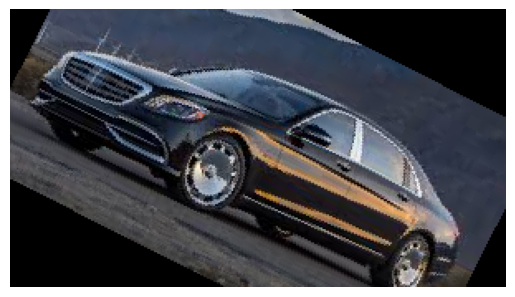

In [4]:
all_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(),
])
all_dataset = Car_vs_Bike_Classification_Dataset(annotation_type = "all", transform=all_transform)

plt.figure()
plt.axis('off')
plt.imshow(all_dataset.__getitem__(150)[0],cmap='gray')

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(),
    transforms.Resize(size=(256,256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256,256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Car_vs_Bike_Classification_Dataset(annotation_type = "train", transform=train_transform)
validation_dataset = Car_vs_Bike_Classification_Dataset(annotation_type = "validation", transform=test_transform)
test_dataset = Car_vs_Bike_Classification_Dataset(annotation_type = "test", transform=test_transform)

### dataloader class object
- batch size는 현재 사용 중인 RTX3060 그래픽 카드의 메모리 사이즈를 가득 채울만큼 크게 잡음.
- batch size는 크면 클수록 성능이 좋아지는 경우도 있다고 함. 아닌 경우도 있음.
- shuffle = True로 설정. 이유는 모델의 일반화 성능이 좋아지는 경향이 있다고 함.
- drop_last = False로 설정. batch size로 전체 데이터를 나누면 나머지가 생기는 데 나머지를 drop 할지 아니면 그대로 진행할지를 결정.

In [6]:
batch_size = 32
shuffle = True
drop_last = False

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = shuffle,
    drop_last = drop_last
)
validation_dataloader = DataLoader(
    dataset = validation_dataset,
    batch_size = batch_size,
    shuffle = shuffle,
    drop_last = drop_last
)
test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = shuffle,
    drop_last = drop_last
)

## Build Your Model

### Model Construction
#### convolution layer construction
- conv2d(kernel_size=3, padding=1) -> relu -> batchnorm2d(optional) -> maxpool2d(kernel_size=2) 이러한 구성을 하나의 convolution layer로 정의.
- 총 5개의 convolution layer가 구성되어 있음.
#### fully connected layer construction
- fully connected layer에 input으로 사용하기 위해 flatten layer를 통해 펼쳐줌.
    - torch.Size([batch, 2048])
- dropout(p=0.3) -> fc -> batchnorm1d -> relu 이러한 구성을 하나의 fc layer로 정의.
- 총 1개의 fc layer가 구성되어 있음.
#### fully connected layer construction (last layer)
- dropoput(p=0.3) -> fc 마지막 fc layer로 구성.
- 마지막 fc layer의 output은 다음과 같이 구성됨.
    - torch.Size([batch, 2])
- car vs bike를 구분하는 문제이기 때문에 마지막 layer output은 2임.
- output 중에서 높은 값의 index를 prediction label로 사용.
<br/><br/>
- 마지막 layer output을 1로 잡고 simoid를 통과한 후 threshold 0.5로 binary 문제를 풀어 보았지만 이유는 모르겠지만 학습이 안되는 현상 확인.
- 아마도 dataset class 정의한 normalize를 하게 되면 음수의 값 또한 의미가 있는 값이기 때문에 그러지 않을까라는 생각을 해봄.

#### How many models analyzed?
- fc layer로만 구성된 모델을 사용해도 의미는 없는 듯하여 이번 과제는 convolution + fc layer로 구성된 모델만 사용.

In [ ]:
class Convolution_Neural_Network_Model(nn.Module):
    def __init__(self, batch_norm_working=False):
        super(Convolution_Neural_Network_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm2d_1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batchnorm2d_2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.batchnorm2d_3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batchnorm2d_4 = nn.BatchNorm2d(1024)
        
        self.conv5 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1)
        self.batchnorm2d_5 = nn.BatchNorm2d(2048)
        
        self.relu = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(kernel_size=2)
        self.adpative_avg_pool2d = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(2048, 2)
        self.batchnorm1d_1 = nn.BatchNorm1d(2048)
        
        self.batch_norm_working = batch_norm_working
        
    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm_working == True:
            x = self.batchnorm2d_1(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        # print(x.shape)
        
        x = self.conv2(x)
        if self.batch_norm_working == True:
            x = self.batchnorm2d_2(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        # print(x.shape)
        
        x = self.conv3(x)
        if self.batch_norm_working == True:
            x = self.batchnorm2d_3(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        # print(x.shape)
        
        x = self.conv4(x)
        if self.batch_norm_working == True:
            x = self.batchnorm2d_4(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        # print(x.shape)
        
        x = self.conv5(x)
        if self.batch_norm_working == True:
            x = self.batchnorm2d_5(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        
        x = self.adpative_avg_pool2d(x)
        x = self.flatten(x)
        
        x = self.dropout(x)
        if self.batch_norm_working == True:
            x = self.batchnorm1d_1(x)
        x = self.fc1(x)
        
        x = x.squeeze().float()
        return x
model = Convolution_Neural_Network_Model(batch_norm_working=False).cuda()

# AlexNet

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 2, bias=True)
model.cuda()

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\user\anaconda3\envs\mldl_class\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\mldl_class\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# ResNet (fine tunning)

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model.fc = torch.nn.Linear(512, 2, bias=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = torch.nn.Linear(2048, 2, bias=True)
model.cuda()

# Model summary

In [8]:
# torchsummary.summary(model, (3,256,256))
torchsummary.summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### check cuda
- 학습을 진행하기 전 cuda 사용 가능 여부 확인

In [9]:
# torch cuda 사용 가능 여부 확인, gpu name 확인, 사용가능 gpu 개수 확인
torch.cuda.is_available(), torch.cuda.get_device_name(), torch.cuda.device_count()

(True, 'NVIDIA GeForce RTX 3060', 1)

### Train Model & Select Model
- loss function으로 cross entropy loss 사용.
- optimizer는 ImageNet task에 사용된 모델의 학습 code들을 참고해보니 adam을 가장 많이 사용하여 adam optimizer 사용.

#### select model
- validation accuracy score가 가장 높은 model을 선택하여  test 진행.
- scikit learn package를 사용하여 accuracy score 및 log loss 측정.

In [10]:
###########################################################################################
# no using batchnorm
# save_model_filename = "./log_file/baseline_model_no_batchnorm.pt"
# save_logging_filename = "./log_file/baseline_model_no_batchnorm_logging.pt"

# using batchnorm
# save_model_filename = "./log_file/baseline_model_yes_batchnorm.pt"
# save_logging_filename = "./log_file/baseline_model_yes_batchnorm_logging.pt"
###########################################################################################
# using data augmentation
# save_model_filename = "./log_file/baseline_model_augmentation.pt"
# save_logging_filename = "./log_file/baseline_model_augmentation_logging.pt"
# save_model_filename = "./log_file/baseline_model_augmentation_500.pt"
# save_logging_filename = "./log_file/baseline_model_augmentation_logging_500.pt"
###########################################################################################
# resnet18
# save_model_filename = "./log_file/resnet18_model.pt"
# save_logging_filename = "./log_file/resnet18_model_logging.pt"

# resnet152
# save_model_filename = "./log_file/resnet152_model.pt"
# save_logging_filename = "./log_file/resnet152_model_logging.pt"
###########################################################################################
# alexnet
save_model_filename = "./log_file/alexnet_model.pt"
save_logging_filename = "./log_file/alexnet_model_logging.pt"
###########################################################################################
epochs = 10

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=0.0001, last_epoch=-1)

train_global_log_loss = []
validation_global_log_loss = []
train_global_accuracy = []
validation_global_accuracy = []

# model selection
validation_best_accuracy_score = 0

model.cuda()
for epoch in range(1,epochs+1):
    train_one_epoch_prediction = []
    train_one_epoch_target = []
    model.train()
    print("="*50)
    print("start training! (epoch : "+str(epoch)+")")
    for x,y in tqdm(train_dataloader):
        x,y = x.cuda(), y.cuda()
        prediction = model(x)
        
        prediction_probability = prediction
        prediction_label = torch.argmax(prediction_probability, dim=1)
        
        train_one_epoch_prediction += prediction_label.cpu().detach().numpy().tolist()
        train_one_epoch_target += y.cpu().detach().numpy().tolist()
        
        loss = loss_function(prediction_probability,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_log_loss = log_loss(train_one_epoch_target, train_one_epoch_prediction)
    train_global_log_loss.append(train_log_loss)
    
    train_accuracy_score = accuracy_score(train_one_epoch_target, train_one_epoch_prediction)
    train_global_accuracy.append(train_accuracy_score)
    
    print("training (log loss) :", train_log_loss)
    print("training (accuracy) :", train_accuracy_score)
    print("end training! (epoch : "+str(epoch)+")")
    
    validation_one_epoch_prediction = []
    validation_one_epoch_target = []
    model.eval()
    print("="*50)
    print("start validation! (epoch : "+str(epoch)+")")
    for x,y in tqdm(validation_dataloader):
        x,y = x.cuda(), y.cuda()
        prediction = model(x)
        
        prediction_probability = prediction
        prediction_label = torch.argmax(prediction_probability, dim=1)
        
        validation_one_epoch_prediction += prediction_label.cpu().detach().numpy().tolist()
        validation_one_epoch_target += y.cpu().detach().numpy().tolist()
    
    
    validation_log_loss = log_loss(validation_one_epoch_target, validation_one_epoch_prediction)
    validation_global_log_loss.append(validation_log_loss)
    validation_accuracy_score = accuracy_score(validation_one_epoch_target, validation_one_epoch_prediction)
    validation_global_accuracy.append(validation_accuracy_score)
    if validation_best_accuracy_score < validation_accuracy_score:
        validation_best_accuracy_score = validation_accuracy_score
        save_dict = {}
        save_dict["epoch"] = epoch
        save_dict["model"] = model
        torch.save(save_dict, save_model_filename)
    
    print("validation (log loss) :", validation_log_loss)
    print("validation (accuracy) :", validation_accuracy_score)
    print("validation best accuracy : ", validation_best_accuracy_score)
    print("end validation! (epoch : "+str(epoch)+")")
    
save_dcit = {}
save_dict["train_global_log_loss"] = train_global_log_loss
save_dict["validation_global_log_loss"] = validation_global_log_loss
save_dict["train_global_accuracy"] = train_global_accuracy
save_dict["validation_global_accuracy"] = validation_global_accuracy
torch.save(save_dict, save_logging_filename)

start training! (epoch : 1)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.11it/s]


training (log loss) : 2.417928414853276
training (accuracy) : 0.9329166666666666
end training! (epoch : 1)
start validation! (epoch : 1)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.68it/s]


validation (log loss) : 0.40549110062756816
validation (accuracy) : 0.98875
validation best accuracy :  0.98875
end validation! (epoch : 1)
start training! (epoch : 2)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:15<00:00,  4.69it/s]


training (log loss) : 1.0963277905856468
training (accuracy) : 0.9695833333333334
end training! (epoch : 2)
start validation! (epoch : 2)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.23it/s]


validation (log loss) : 0.7208730677823434
validation (accuracy) : 0.98
validation best accuracy :  0.98875
end validation! (epoch : 2)
start training! (epoch : 3)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.00it/s]


training (log loss) : 0.9761822792885899
training (accuracy) : 0.9729166666666667
end training! (epoch : 3)
start validation! (epoch : 3)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.92it/s]


validation (log loss) : 0.36043653389117175
validation (accuracy) : 0.99
validation best accuracy :  0.99
end validation! (epoch : 3)
start training! (epoch : 4)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:16<00:00,  4.68it/s]


training (log loss) : 0.7208730677823433
training (accuracy) : 0.98
end training! (epoch : 4)
start validation! (epoch : 4)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.47it/s]


validation (log loss) : 0.40549110062756816
validation (accuracy) : 0.98875
validation best accuracy :  0.99
end validation! (epoch : 4)
start training! (epoch : 5)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:15<00:00,  4.92it/s]


training (log loss) : 0.5256366119246254
training (accuracy) : 0.9854166666666667
end training! (epoch : 5)
start validation! (epoch : 5)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.50it/s]


validation (log loss) : 0.40549110062756816
validation (accuracy) : 0.98875
validation best accuracy :  0.99
end validation! (epoch : 5)
start training! (epoch : 6)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:15<00:00,  4.99it/s]


training (log loss) : 0.5106184230124932
training (accuracy) : 0.9858333333333333
end training! (epoch : 6)
start validation! (epoch : 6)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.78it/s]


validation (log loss) : 0.3153819671547753
validation (accuracy) : 0.99125
validation best accuracy :  0.99125
end validation! (epoch : 6)
start training! (epoch : 7)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:15<00:00,  4.94it/s]


training (log loss) : 0.6457821232216825
training (accuracy) : 0.9820833333333333
end training! (epoch : 7)
start validation! (epoch : 7)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.36it/s]


validation (log loss) : 0.4505456673639646
validation (accuracy) : 0.9875
validation best accuracy :  0.99125
end validation! (epoch : 7)
start training! (epoch : 8)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.14it/s]


training (log loss) : 0.6007275564852861
training (accuracy) : 0.9833333333333333
end training! (epoch : 8)
start validation! (epoch : 8)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.59it/s]


validation (log loss) : 0.31538196715477523
validation (accuracy) : 0.99125
validation best accuracy :  0.99125
end validation! (epoch : 8)
start training! (epoch : 9)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.28it/s]


training (log loss) : 0.390472911715436
training (accuracy) : 0.9891666666666666
end training! (epoch : 9)
start validation! (epoch : 9)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.88it/s]


validation (log loss) : 0.2252728336819824
validation (accuracy) : 0.99375
validation best accuracy :  0.99375
end validation! (epoch : 9)
start training! (epoch : 10)


100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.09it/s]


training (log loss) : 0.5556729897488896
training (accuracy) : 0.9845833333333334
end training! (epoch : 10)
start validation! (epoch : 10)


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.70it/s]


validation (log loss) : 0.31538196715477523
validation (accuracy) : 0.99125
validation best accuracy :  0.99375
end validation! (epoch : 10)


### results plot
- training & validation log loss & accuracy score를 그려봄.
- x축에서 수직선은 그 epoch에서의 model 선택.

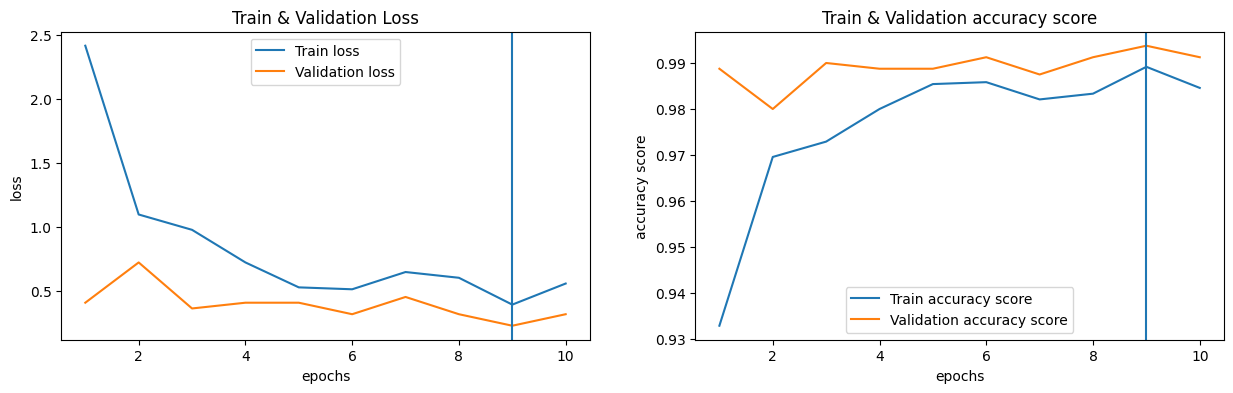

In [11]:
###########################################################################################
# no using batchnorm
# save_model_filename = "./log_file/baseline_model_no_batchnorm.pt"
# save_logging_filename = "./log_file/baseline_model_no_batchnorm_logging.pt"

# using batchnorm
# save_model_filename = "./log_file/baseline_model_yes_batchnorm.pt"
# save_logging_filename = "./log_file/baseline_model_yes_batchnorm_logging.pt"
###########################################################################################
# using data augmentation
# save_model_filename = "./log_file/baseline_model_augmentation.pt"
# save_logging_filename = "./log_file/baseline_model_augmentation_logging.pt"
# save_model_filename = "./log_file/baseline_model_augmentation_500.pt"
# save_logging_filename = "./log_file/baseline_model_augmentation_logging_500.pt"
###########################################################################################
# resnet18
# save_model_filename = "./log_file/resnet18_model.pt"
# save_logging_filename = "./log_file/resnet18_model_logging.pt"

# resnet152
# save_model_filename = "./log_file/resnet152_model.pt"
# save_logging_filename = "./log_file/resnet152_model_logging.pt"
###########################################################################################
# alexnet
save_model_filename = "./log_file/alexnet_model.pt"
save_logging_filename = "./log_file/alexnet_model_logging.pt"
###########################################################################################
save_dict = torch.load(save_model_filename)
best_epoch = save_dict["epoch"]

log_dict = torch.load(save_logging_filename)
train_global_log_loss = log_dict["train_global_log_loss"]
validation_global_log_loss = log_dict["validation_global_log_loss"]
train_global_accuracy = log_dict["train_global_accuracy"]
validation_global_accuracy = log_dict["validation_global_accuracy"]

epochs = range(1, len(train_global_log_loss) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_global_log_loss, label='Train loss')
plt.plot(epochs, validation_global_log_loss, label='Validation loss')
plt.axvline(x=best_epoch)

plt.title('Train & Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_global_accuracy, label='Train accuracy score')
plt.plot(epochs, validation_global_accuracy, label='Validation accuracy score')
plt.axvline(x=best_epoch)

plt.title('Train & Validation accuracy score')
plt.xlabel('epochs')
plt.ylabel('accuracy score')
plt.legend()

plt.show()

---

## Performance

In [12]:
load_dict = torch.load(save_model_filename)
model = load_dict["model"].cpu()

with torch.no_grad():
    test_one_epoch_prediction = []
    test_one_epoch_target = []
    model.eval()
    print("start test!")
    for x,y in tqdm(test_dataloader):
        prediction_probability = model(x)
        prediction_label = torch.argmax(prediction_probability, dim=1)
        
        test_one_epoch_prediction += prediction_label.detach().numpy().tolist()
        test_one_epoch_target += y.detach().numpy().tolist()
        
    test_accuracy_score = accuracy_score(test_one_epoch_target, test_one_epoch_prediction)
    
    print("test_accuracy_score :", test_accuracy_score)
    print("test_confusion_matrix :")
    print(confusion_matrix(test_one_epoch_prediction,test_one_epoch_target))

start test!


100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.26it/s]

test_accuracy_score : 0.99125
test_confusion_matrix :
[[401   3]
 [  4 392]]
